# 00. PyTorch Fundamentals Exercises

1. Create a straight line dataset using the linear regression formula (`weight * X + bias`):
* Set `weight=0.3` and `bias=0.9` there should be at least 100 datapoints total.
* Split the data into 80% training, 20% testing.
* Plot the training and testing data so it becomes visual.

In [68]:
import torch
from torch import nn
import matplotlib.pyplot as plt

In [69]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device {device}")

Using device cpu


In [70]:
# Creating data

weight, bias = 0.3, 0.9

start, end = 0, 1
step = 0.01         # Creates 100 datapoints
X = torch.arange(start, end, step)
y = weight * X + bias

X[:5], y[:5]

(tensor([0.0000, 0.0100, 0.0200, 0.0300, 0.0400]),
 tensor([0.9000, 0.9030, 0.9060, 0.9090, 0.9120]))

In [71]:
# Splitting data

train_split = int(0.8 * len(X))
X_train, y_train = X[:train_split], y[:train_split]
X_test, y_test = X[train_split:], y[train_split:]

len(X_train), len(y_train), len(X_test), len(y_test)

(80, 80, 20, 20)

In [72]:
def plot_predictions(train_data = X_train, train_labels = y_train,
                     test_data = X_test, test_labels = y_test, predictions=None):
    # Plots training data, testing data and compares predictions
    plt.figure(figsize=(10, 7))

    # Plot training data in blue
    plt.scatter(train_data, train_labels, c="b", s=4, label="Training Data")    # c="b" for blue, s for size of the marker
    
    # Plot test data in green
    plt.scatter(test_data, test_labels, c="g", s=4, label="Test data")
    
    # Are there predictions?
    if predictions is not None:
        # Plotting predictions if they exist
        plt.scatter(test_data, predictions, c="r", s=4, label="Predictions")
        
    # Showing the legend
    plt.legend(prop={"size": 14})

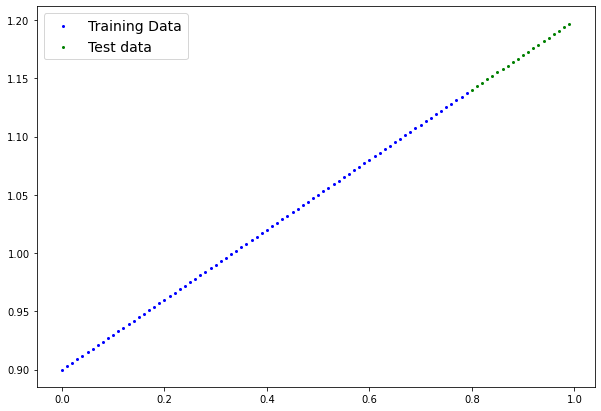

In [73]:
plot_predictions()

2. Build a PyTorch model by subclassing `nn.Module`.
* Inside should be a randomly initialized `nn.Parameter()` with `requires_grad=True`, one for `weights` and one for `bias`.
* Implement the `forward()` method to compute the linear regression function you used to create the dataset in 1.
* Once you've constructed the model, make an instance of it and check its `state_dict()`.
* **Note:** If you'd like to use `nn.Linear()` instead of `nn.Parameter()` you can.

In [74]:
# Creating linear regression model class

class LinearRegressionModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_layer = nn.Linear(in_features=1, out_features=1)    # Input size = Output size = 1
        
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear_layer(x)

In [75]:
# Checking out the model's state dictionary

torch.manual_seed(42)

model = LinearRegressionModel()
model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.7645]])),
             ('linear_layer.bias', tensor([0.8300]))])

3. Create a loss function and optimizer using `nn.L1Loss()` and `torch.optim.SGD(params, lr)` respectively.
* Set the learning rate of the optimizer to be 0.01 and the parameters to optimize should be the model parameters from the model you created in 2.
* Write a training loop to perform the appropriate training steps for 300 epochs.
* The training loop should test the model on the test dataset every 20 epochs.

In [76]:
# Ensuring everything is on target device

model.to(device)
next(model.parameters()).device

device(type='cpu')

In [77]:
# Creating a loss function and optimizer

loss_fn = nn.L1Loss()
optimizer = torch.optim.SGD(params=model.parameters(), lr=0.01)

In [78]:
# Ensuring correct tensor shape

def ensure_correct_shape(tensor):
    if len(tensor.shape) == 1:  
        tensor = tensor.view(-1, 1)    
    return tensor

X_train = ensure_correct_shape(X_train)
X_test = ensure_correct_shape(X_test)
y_train = ensure_correct_shape(y_train)
y_test = ensure_correct_shape(y_test)


In [79]:
torch.manual_seed(42)

X_train = X_train.to(device)
X_test = X_test.to(device)
y_train = y_train.to(device)
y_test = y_test.to(device)

epochs = 300

for epoch in range(epochs):
    
    # Training
    model.train()
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train)         # Training loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # Testing
    model.eval()
    with torch.inference_mode():
        test_pred = model(X_test)
        test_loss = loss_fn(test_pred, y_test)
    if epoch % 20 == 0:
        print(f"Epoch: {epoch} | Loss: {loss} | Test Loss: {test_loss}")

Epoch: 0 | Loss: 0.12756133079528809 | Test Loss: 0.33650320768356323
Epoch: 20 | Loss: 0.08187223970890045 | Test Loss: 0.2184026539325714
Epoch: 40 | Loss: 0.07207288593053818 | Test Loss: 0.17458662390708923
Epoch: 60 | Loss: 0.06507987529039383 | Test Loss: 0.15310418605804443
Epoch: 80 | Loss: 0.05822876840829849 | Test Loss: 0.1367770880460739
Epoch: 100 | Loss: 0.05137667804956436 | Test Loss: 0.12079393863677979
Epoch: 120 | Loss: 0.044525571167469025 | Test Loss: 0.10446684062480927
Epoch: 140 | Loss: 0.037674423307180405 | Test Loss: 0.08813951164484024
Epoch: 160 | Loss: 0.03082224354147911 | Test Loss: 0.0721558928489685
Epoch: 180 | Loss: 0.02397105097770691 | Test Loss: 0.055828340351581573
Epoch: 200 | Loss: 0.01711984910070896 | Test Loss: 0.03950077295303345
Epoch: 220 | Loss: 0.010267667472362518 | Test Loss: 0.02351721003651619
Epoch: 240 | Loss: 0.0034169009886682034 | Test Loss: 0.007191836833953857
Epoch: 260 | Loss: 0.007878491654992104 | Test Loss: 0.00706424703

4. Make predictions with the trained model on the test data.
* Visualize these predictions against the original training and testing data (**note:** you may need to make sure the predictions are not on the GPU if you want to use non-CUDA-enabled libraries such as matplotlib to plot).

In [80]:
model.eval()
with torch.inference_mode():
    y_preds = model(X_test)

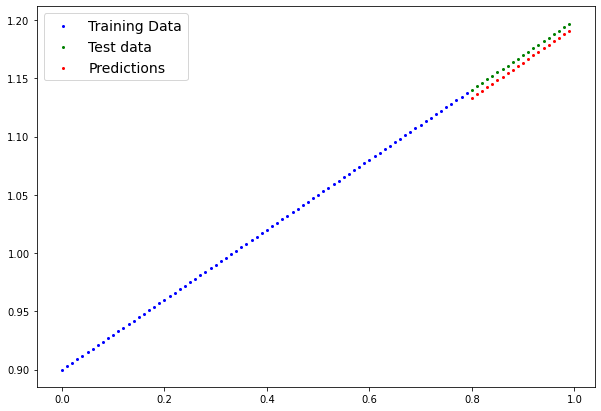

In [81]:
plot_predictions(predictions=y_preds)

5. Save your trained model's `state_dict()` to file.
* Create a new instance of your model class you made in 2. and load in the `state_dict()` you just saved to it.
* Perform predictions on your test data with the loaded model and confirm they match the original model predictions from 4.

In [84]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "01_pytorch_workflow_exercises_model.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

print(f"Saving model to {MODEL_SAVE_PATH}")
torch.save(obj=model.state_dict(), f=MODEL_SAVE_PATH)

Saving model to models\01_pytorch_workflow_exercises_model.pth


In [89]:
loaded_model = LinearRegressionModel()
loaded_model.load_state_dict(torch.load(MODEL_SAVE_PATH))

loaded_model.to(device)
next(loaded_model.parameters()).device

device(type='cpu')

In [90]:
loaded_model.state_dict()

OrderedDict([('linear_layer.weight', tensor([[0.3028]])),
             ('linear_layer.bias', tensor([0.8910]))])

In [91]:
loaded_model.eval()
with torch.inference_mode():
    loaded_model_preds = loaded_model(X_test)

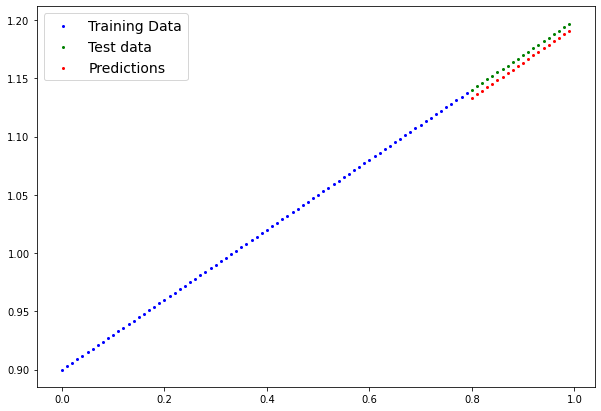

In [93]:
plot_predictions(predictions=loaded_model_preds)